In [11]:
import numpy as np
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps
from shapely.geometry import Point

In [15]:
regiones = gpd.read_file(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\hidrogeologia\hydrogeol_provs_rapid_invPolygon.shp')
print(regiones.columns)

Index(['REPORT_LIN', 'INVENTORYN', 'PROVINCE_N', 'MAJOR_AQUI', 'HYDROGEOLO',
       'GROUNDWATE', 'SALINITY_5', 'SALINITY_9', 'SWL_5TH_PE', 'SWL_95TH_P',
       'IMPORTANT_', 'NATIVE_TIT', 'SUMMARY', 'MAIN_POPUL', 'GEOLOGICAL',
       'GEOLOGICA0', 'GEOLOGICA1', 'TOTAL_AREA', 'ONSHORE_AR', 'TOPO_FEATU',
       'geometry'],
      dtype='object')


In [17]:
npfile = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheilsen_SWL.npz')
print(npfile.files)

['swl_syr', 'swl_condyr', 'swl_s_nmax_yr', 'swl_nmax_yr', 'swl_vyr', 'swl_resyr', 'HydroID', 'lat', 'lon', 'swl_interc_t', 'swl_slop_t']


In [19]:
swl_syr       = npfile.f.swl_syr
swl_condyr    = npfile.f.swl_condyr
swl_s_nmax_yr = npfile.f.swl_s_nmax_yr
swl_nmax_yr   = npfile.f.swl_nmax_yr
swl_vyr       = npfile.f.swl_vyr
swl_resyr     = npfile.f.swl_resyr
HydroID       = npfile.f.HydroID
lat           = npfile.f.lat
lon           = npfile.f.lon
swl_interc_t  = npfile.f.swl_interc_t
swl_slop_t    = npfile.f.swl_slop_t

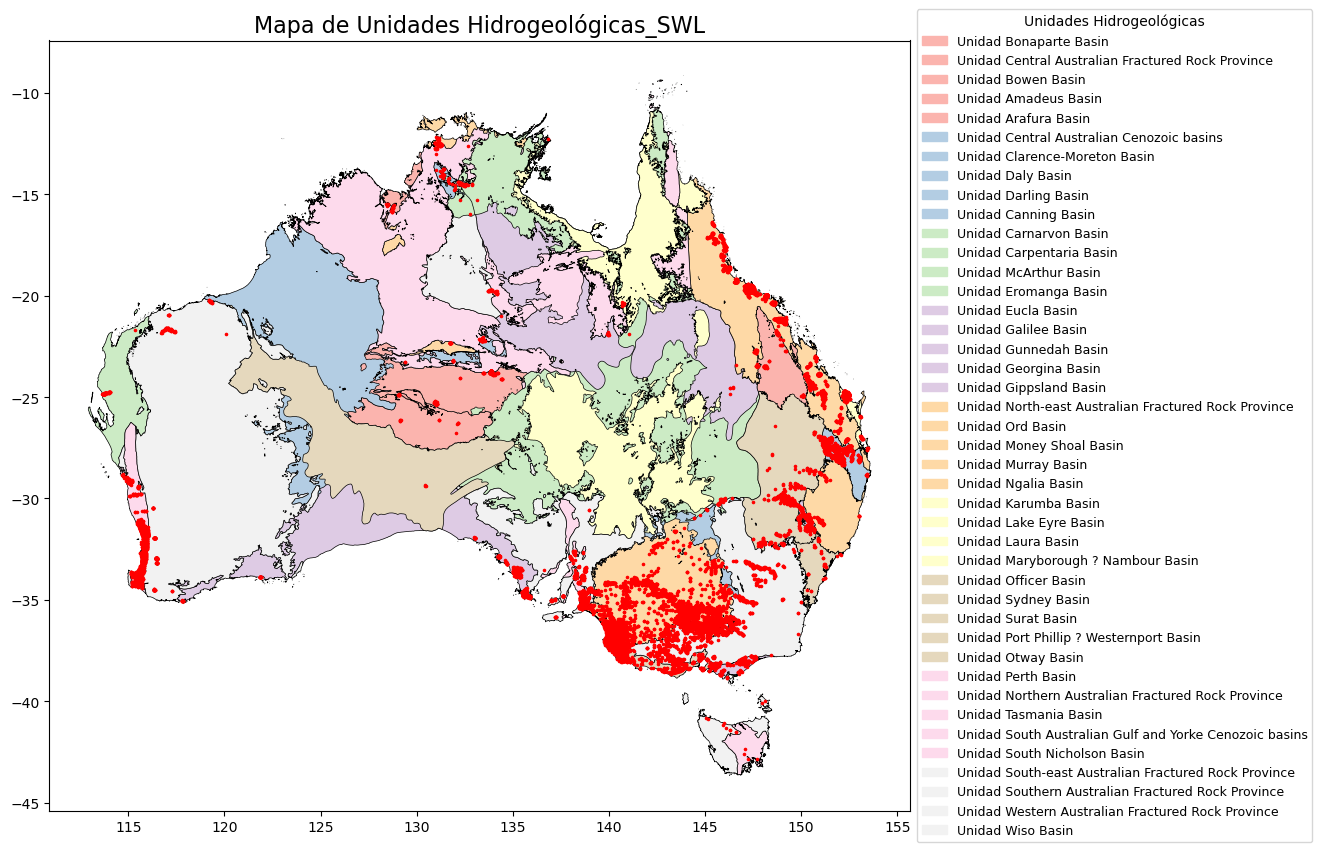

In [21]:
def vis_pozos(shp_path, npz_paths):
  
    mapa = gpd.read_file(shp_path)
    all_lon = []
    all_lat = []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['swl_condyr'] == 1
        all_lon.append(pozos['lon'][mask])
        all_lat.append(pozos['lat'][mask])

    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)

    # Generar colores para las regiones
    unique_regions = mapa['PROVINCE_N'].unique()
    cmap = colormaps.get_cmap('Pastel1')  
    region_colors = {region: cmap(i / len(unique_regions)) for i, region in enumerate(unique_regions)}  # Asignar colores

    fig, ax = plt.subplots(figsize=(15, 10))
    for region, color in region_colors.items():
        mapa[mapa['PROVINCE_N'] == region].plot(ax=ax, color=color, edgecolor='black', linewidth=0.5)

    ax.scatter(lon, lat, color='red', marker='.', s=10, label='Pozos')
    ax.set_title('Mapa de Unidades Hidrogeológicas_SWL', fontsize=16)
    region_patches = [mpatches.Patch(color=color, label=f'Unidad {region}') for region, color in region_colors.items()]
    ax.legend(handles=region_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, title="Unidades Hidrogeológicas")
    plt.subplots_adjust(right=0.8)
    plt.show()

shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\hidrogeologia\hydrogeol_provs_rapid_invPolygon.shp'
npz_path = [r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheilsen_SWL.npz']

vis_pozos(shp_path, npz_path)

In [25]:
def vis_pozos_por_region(shp_path, npz_paths, output_folder):
    # Cargar shapefile y verificar proyección
    mapa = gpd.read_file(shp_path)
    if mapa.crs is None:
        raise ValueError("El shapefile no tiene un sistema de coordenadas definido.")
    print(f"CRS del shapefile: {mapa.crs}")
    
    # Listas para almacenar coordenadas de todos los pozos
    all_lon = []
    all_lat = []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        if 'lon' not in pozos or 'lat' not in pozos or 'swl_condyr' not in pozos:
            raise ValueError(f"El archivo {npz_path} no contiene las claves necesarias ('lon', 'lat', 'dtw_condyr').")
        
        # Filtrar pozos válidos
        mask = pozos['swl_condyr'] == 1
        all_lon.append(pozos['lon'][mask])
        all_lat.append(pozos['lat'][mask])

    # Combinar todas las coordenadas de pozos
    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)

    # Crear un GeoDataFrame para los pozos
    pozos_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(lon, lat)], crs="EPSG:4326")
    if pozos_gdf.crs != mapa.crs:
        pozos_gdf = pozos_gdf.to_crs(mapa.crs)

    # Intersección espacial para asignar pozos a regiones
    pozos_asignados = gpd.sjoin(pozos_gdf, mapa, how='inner', predicate='intersects')

    # Contar pozos por región
    pozos_por_region = pozos_asignados['PROVINCE_N'].value_counts()

    # Graficar un zoom por cada región con pozos
    for region, count in pozos_por_region.items():
        print(f'Región: {region}, Pozos: {count}')
        
        region_geom = mapa[mapa['PROVINCE_N'] == region]

    
        pozos_region = pozos_asignados[pozos_asignados['PROVINCE_N'] == region]

        fig, ax = plt.subplots(figsize=(10, 8))
        region_geom.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5)
        pozos_region.plot(ax=ax, color='red', marker='.', markersize=10, label='Pozos')

        ax.set_title(f'Unidad: {region} (Pozos: {count})', fontsize=14)
        ax.legend()
        output_file = f"{output_folder}/SWLunidad_{re.sub(r'[^a-zA-Z0-9_]', '_', region)}.png"
        plt.savefig(output_file, bbox_inches='tight')
        plt.close()

# Rutas de los archivos
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\hidrogeologia\hydrogeol_provs_rapid_invPolygon.shp'
npz_paths = [r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheilsen_SWL.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheilsen_SWL.npz'
    
]
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\images'

# Llamar a la función
vis_pozos_por_region(shp_path, npz_paths, output_folder)

CRS del shapefile: EPSG:4326
Región: Murray Basin, Pozos: 4383
Región: North-east Australian Fractured Rock Province, Pozos: 2748
Región: Perth Basin, Pozos: 1725
Región: South-east Australian Fractured Rock Province, Pozos: 1023
Región: Clarence-Moreton Basin, Pozos: 623
Región: Otway Basin, Pozos: 600
Región: Maryborough ? Nambour Basin, Pozos: 507
Región: Gunnedah Basin, Pozos: 501
Región: Surat Basin, Pozos: 469
Región: Eucla Basin, Pozos: 443
Región: South Australian Gulf and Yorke Cenozoic basins, Pozos: 407
Región: Southern Australian Fractured Rock Province, Pozos: 328
Región: Gippsland Basin, Pozos: 244
Región: Darling Basin, Pozos: 198
Región: Port Phillip ? Westernport Basin, Pozos: 178
Región: Western Australian Fractured Rock Province, Pozos: 163
Región: Amadeus Basin, Pozos: 153
Región: Bowen Basin, Pozos: 129
Región: Northern Australian Fractured Rock Province, Pozos: 107
Región: Central Australian Cenozoic basins, Pozos: 71
Región: Carnarvon Basin, Pozos: 69
Región: Mon